# The base classes of paintbox

The spectral energy distribution (SED) of galaxies can be decomposited into different components, including the light from the stars, the emission lines from the gas, and the attenuation of the light as a whole owing to dust absorption. Moreover, the observed SED can also contain emission and absorption from non-astrophysical processes, such as sky and telluric emission, and other residual effects from the telescope/instrument. Therefore, the philosophy of `paintbox` is to provide tools to build spectra for each of these components and combine them together to produce a SED model. In the next sections we indicate different ways to produce these SED components.

## Stellar components 

The optical and near-infrared spectra of stellar systems (galaxies, globular clusters, individual starls) show a complex variation of the intensity of light as a function of the wavelength, featuring thousands of absorption lines on top of a varying continuum emission. Consequently, models of stars and stellar populations are distributed in the form of libraries, containing templates (spectra) that change according to some parameters (temperature, age, etc). These libraries are **not** distributed with `paintbox`, and do not have a standard distribution format. Thus, in the examples we use one example of stellar library from [Coelho (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.1027C/abstract), which you can download [here](http://specmodels.iag.usp.br/). Here we define a routine to load the data into tables and arrays that we use in the examples below. 

In [7]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack

def read_Coelho2014(models_dir=None):
    # Subdirectory where models are stored.
    models_dir = "s_coelho14_sed" if models_dir is None else models_dir
    # Getting parameters from file names
    model_names = [_ for _ in os.listdir(models_dir) if _.endswith(".fits")]
    # Get dispersion from the header of a file
    filename = os.path.join(models_dir, model_names[0])
    crval1 = fits.getval(filename, "CRVAL1")
    cdelt1 = fits.getval(filename, "CDELT1")
    n = fits.getval(filename, "NAXIS1")
    pix = np.arange(n) + 1
    wave = np.power(10, crval1 + cdelt1 * pix) * u.micrometer
    # Create an table with parameters based on the file names
    table = []
    # Also store all templates into a 2D array
    templates = np.zeros((len(model_names), n))
    for i, filename in enumerate(model_names):
        T = float(filename.split("_")[0][1:])
        g = float(filename.split("_")[1][1:])
        Z = 0.1 * float(filename.split("_")[2][:3].replace(
            "m", "-").replace("p", "+"))
        alpha = 0.1 * float(filename.split("_")[2][3:].replace(
            "m", "-").replace("p", "+"))
        a = np.array([T, g, Z, alpha])
        t = Table(a, names=["T", "g", "Z", "alpha"])
        table.append(t)
        templates[i] = fits.getdata(os.path.join(models_dir, filename))
    table = vstack(table) # Join all tables in one
    return wave, table, templates

### Parametric models

Model allowed ranges
{'T': (3000.0, 26000.0), 'g': (-0.5, 5.5), 'Z': (-1.3, 0.2), 'alpha': (0.0, 0.4)}
List of parameters of model
['T', 'g', 'Z', 'alpha']


Text(0, 0.5, 'Normalized Flux')

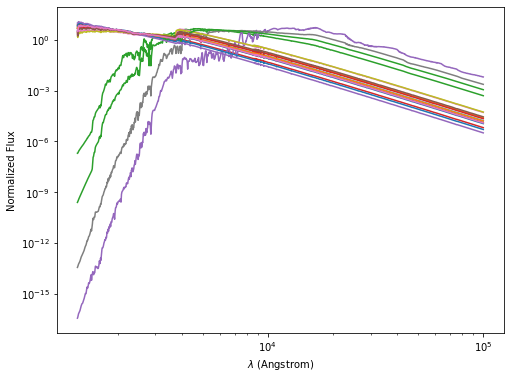

In [10]:
import matplotlib.pyplot as plt
import paintbox as pb

wave, params, templates = read_Coelho2014()

star = pb.ParametricModel(wave, params, templates)
# Plotting n random models
fig = plt.figure(figsize=(8, 6))
n = 50
print("Model allowed ranges")
print(star.limits)
print("List of parameters of model")
print(star.parnames)
for i in range(n):
    # Generating a random vector within the limits of the models
    theta = np.array([np.random.uniform(star.limits[p][0], star.limits[p][1]) 
                      for p in star.parnames])
    # Get interpolated model
    y = star(theta)
    # These particular models do not form a regular grid in the parameter space.
    # Models outside the parameter space convex-hull return zero by paintbox.
    # We avoid ploting these cases in the plotting
    if all(y) == 0:  
        continue
    plt.loglog(wave, y / y.mean())
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Normalized Flux")
# plt.savefig("../docs/figures/interpolated_star.png")